<a href="https://colab.research.google.com/github/SampMark/Machine-Learn/blob/main/DBSCAN_Clustering_Weather_Station.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clusterização espacial com o DBSCAN**: utilizando dados de estações meteorológicas do Canada

O algoritmo DBSCAN destaca-se em tarefas de clusterização espacial, especialmente na identificação de classes em contextos geográficos. Sua principal vantagem reside na capacidade de encontrar clusters de formatos arbitrários e lidar com ruído de forma eficaz.

Um exemplo prático da aplicação do DBSCAN é a clusterização de estações meteorológicas. Ao analisar dados de localização, o algoritmo pode agrupar estações que compartilham condições climáticas semelhantes, como temperatura, precipitação e umidade. Essa capacidade de identificar padrões em dados espaciais torna o DBSCAN uma ferramenta útil para análise geográfica e meteorológica, por exemplo.

In [26]:
!pip install basemap scikit-learn #cartopy folium

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
import numpy as np
import sklearn.utils
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.basemap import Basemap
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
from pylab import rcParams

## **Fluxo de Trabalho**

---



Para realizar a clusterização das estações meteorológicas, seguiremos o seguinte fluxo de trabalho:

1. **Carregamento dos Dados**: importação dos dados de localização das estações meteorológicas.
2. **Exploração dos Dados**: Análise exploratória dos dados para entender sua estrutura e características.
3. **Limpeza dos Dados**: Tratamento de dados ausentes, inconsistentes ou errôneos.
4. **Seleção das Variáveis**: escolha das variáveis relevantes para a clusterização.
5. **Clusterização DBSCAN**: aplicação do algoritmo DBSCAN com os parâmetros adequados para agrupar as estações.

## **Carregamento do DataSet**

---



In [28]:
# URL do dataset
url = 'https://raw.githubusercontent.com/SampMark/files/refs/heads/main/weather-stations20140101-20141231.csv'

# Validar a URL antes de tentar carregar os dados
try:
    response = requests.head(url)
    if response.status_code == 200:
        print("URL acessível. Carregando os dados...")
    else:
        print("URL inacessível. Verifique o link fornecido.")
        exit()
except Exception as e:
    print(f"Erro ao acessar a URL: {e}")
    exit()

# Ler o dataset
pdf = pd.read_csv(url)

# Informações gerais sobre o dataset
print("\nVisão geral do dataset:")
print(f"- Número de linhas: {pdf.shape[0]}")
print(f"- Número de colunas: {pdf.shape[1]}")

# Verificar as primeiras linhas
print("\nPrimeiras 5 linhas do dataset:")
pdf.head(5)

URL acessível. Carregando os dados...

Visão geral do dataset:
- Número de linhas: 1341
- Número de colunas: 25

Primeiras 5 linhas do dataset:


Stn_Name     Lat     Long Prov   Tm  DwTm    D    Tx  DwTx  \
0               CHEMAINUS  48.935 -123.742   BC  8.2   0.0  NaN  13.5   0.0   
1  COWICHAN LAKE FORESTRY  48.824 -124.133   BC  7.0   0.0  3.0  15.0   0.0   
2           LAKE COWICHAN  48.829 -124.052   BC  6.8  13.0  2.8  16.0   9.0   
3        DISCOVERY ISLAND  48.425 -123.226   BC  NaN   NaN  NaN  12.5   0.0   
4     DUNCAN KELVIN CREEK  48.735 -123.728   BC  7.7   2.0  3.4  14.5   2.0   

    Tn  ...  DwP    P%N  S_G    Pd  BS  DwBS  BS%    HDD  CDD   Stn_No  
0  1.0  ...  0.0    NaN  0.0  12.0 NaN   NaN  NaN  273.3  0.0  1011500  
1 -3.0  ...  0.0  104.0  0.0  12.0 NaN   NaN  NaN  307.0  0.0  1012040  
2 -2.5  ...  9.0    NaN  NaN  11.0 NaN   NaN  NaN  168.1  0.0  1012055  
3  NaN  ...  NaN    NaN  NaN   NaN NaN   NaN  NaN    NaN  NaN  1012475  
4 -1.0  ...  2.0    NaN  NaN  11.0 NaN   NaN  NaN  267.7  0.0  1012573  

[5 rows x 25 columns]

In [29]:
# Exibir as colunas para referência
print("\nLista de colunas disponíveis:")
print(pdf.columns.tolist())


Lista de colunas disponíveis:
['Stn_Name', 'Lat', 'Long', 'Prov', 'Tm', 'DwTm', 'D', 'Tx', 'DwTx', 'Tn', 'DwTn', 'S', 'DwS', 'S%N', 'P', 'DwP', 'P%N', 'S_G', 'Pd', 'BS', 'DwBS', 'BS%', 'HDD', 'CDD', 'Stn_No']


### **Detalhamento sobre as variáveis**

| **Variáveis** | **Significado**                                                                                                                                              |
|---------------|------------------------------------------------------------------------------------------------------------------------|
| Stn_Name      | Nome da Estação                                                                                                                                             |
| Lat           | Latitude (Norte - graus)                                                                                                                                    |
| Long          | Longitude (Oeste - graus)                                                                                                                                   |
| Prov          | Província                                                                                                                                                  |
| Tm            | Temperatura Média (°C)                                                                                                                                     |
| DwTm          | Dias sem Temperatura Média Válida                                                                                                                          |
| D             | Diferença da Temperatura Média em relação ao Normal (1981-2010) (°C)                                                                                       |
| Tx            | Temperatura Máxima Mensal Mais Alta (°C)                                                                                                                   |
| DwTx          | Dias sem Temperatura Máxima Válida                                                                                                                         |
| Tn            | Temperatura Mínima Mensal Mais Baixa (°C)                                                                                                                  |
| DwTn          | Dias sem Temperatura Mínima Válida                                                                                                                         |
| S             | Queda de Neve (cm)                                                                                                                                         |
| DwS           | Dias sem Queda de Neve Válida                                                                                                                              |
| S\%N          | Porcentagem da Queda de Neve Normal (1981-2010)                                                                                                            |
| P             | Precipitação Total (mm)                                                                                                                                     |
| DwP           | Dias sem Precipitação Válida                                                                                                                               |
| P\%N          | Porcentagem da Precipitação Normal (1981-2010)                                                                                                             |
| SG            | Neve no solo no final do mês (cm)                                                                                                                          |
| Pd            | Número de dias com Precipitação ≥ 1.0 mm ou mais                                                                                                           |
| BS            | Brilho do Sol (horas)                                                                                                                                      |
| DwBS          | Dias sem Brilho do Sol Válido                                                                                                                              |
| BS\%N         | Porcentagem do Brilho do Sol Normal (1981-2010)                                                                                                            |
| HDD           | Graus-Dia abaixo de 18 °C                                                                                                                                  |
| CDD           | Graus-Dia acima de 18 °C                                                                                                                                   |
| Stn_No        | Identificador da estação climática (os primeiros 3 dígitos indicam a bacia de drenagem, os últimos 4 caracteres são para classificação alfabética).         |
| NA            | Não Disponível                                                                                                                                             |


In [30]:
# Mostrar informações sobre colunas e tipos de dados
print("\nInformações das colunas:")
print(pdf.info())


Informações das colunas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Stn_Name  1341 non-null   object 
 1   Lat       1341 non-null   float64
 2   Long      1341 non-null   float64
 3   Prov      1341 non-null   object 
 4   Tm        1256 non-null   float64
 5   DwTm      1256 non-null   float64
 6   D         357 non-null    float64
 7   Tx        1260 non-null   float64
 8   DwTx      1260 non-null   float64
 9   Tn        1260 non-null   float64
 10  DwTn      1260 non-null   float64
 11  S         586 non-null    float64
 12  DwS       586 non-null    float64
 13  S%N       198 non-null    float64
 14  P         1227 non-null   float64
 15  DwP       1227 non-null   float64
 16  P%N       209 non-null    float64
 17  S_G       798 non-null    float64
 18  Pd        1227 non-null   float64
 19  BS        0 non-null      float64
 20  DwBS

### **Sumário Estatístico**

---



In [31]:
# Resumo estatístico das colunas numéricas
print("\nResumo estatístico das colunas numéricas:")
print(pdf.describe())


Resumo estatístico das colunas numéricas:
               Lat         Long           Tm         DwTm           D  \
count  1341.000000  1341.000000  1256.000000  1256.000000  357.000000   
mean     51.185221   -96.670827   -12.062341     2.186306   -2.768908   
std       6.216434    23.285512    10.416366     4.903077    4.840769   
min      41.949000  -140.868000   -38.200000     0.000000  -12.000000   
25%      46.983000  -116.501000   -18.500000     0.000000   -7.100000   
50%      49.850000  -101.400000   -13.800000     0.000000   -4.600000   
75%      53.283000   -73.750000    -5.600000     2.000000    2.700000   
max      82.500000   -52.753000     9.600000    27.000000    7.800000   

                Tx         DwTx           Tn         DwTn           S  ...  \
count  1260.000000  1260.000000  1260.000000  1260.000000  586.000000  ...   
mean      2.612302     1.814286   -26.322381     1.816667   35.219966  ...   
std       8.855823     4.249613    12.573066     4.438321   39.57

## **Limpeza dos Dados**

---



In [32]:
# Verificar valores nulos
print("\nNúmero de valores nulos por coluna:")
print(pdf.isnull().sum())


Número de valores nulos por coluna:
Stn_Name       0
Lat            0
Long           0
Prov           0
Tm            85
DwTm          85
D            984
Tx            81
DwTx          81
Tn            81
DwTn          81
S            755
DwS          755
S%N         1143
P            114
DwP          114
P%N         1132
S_G          543
Pd           114
BS          1341
DwBS        1341
BS%         1341
HDD           85
CDD           85
Stn_No         0
dtype: int64


Para limpeza `dropna` é mais conciso e direto para remover valores nulos de uma ou mais colunas, e `reset_index` garante que os índices permanençam consecutivos após a remoção de linhas.

In [33]:
# Remover as linhas com valores nulos no campo "Tm" e reiniciar o índice
pdf = pdf.dropna(subset=["Tm"]).reset_index(drop=True)

# Imprimir o número atualizado de linhas e colunas após a limpeza
print("\nApós remover valores nulos em 'Tm':")
print(f"- Número de linhas: {pdf.shape[0]}")
print(f"- Número de colunas: {pdf.shape[1]}")

# Visualizar as primeiras 5 linhas do dataset
print("\nPrimeiras 5 linhas do dataset limpo:")
pdf.head(5)


Após remover valores nulos em 'Tm':
- Número de linhas: 1256
- Número de colunas: 25

Primeiras 5 linhas do dataset limpo:


Stn_Name     Lat     Long Prov   Tm  DwTm    D    Tx  DwTx  \
0               CHEMAINUS  48.935 -123.742   BC  8.2   0.0  NaN  13.5   0.0   
1  COWICHAN LAKE FORESTRY  48.824 -124.133   BC  7.0   0.0  3.0  15.0   0.0   
2           LAKE COWICHAN  48.829 -124.052   BC  6.8  13.0  2.8  16.0   9.0   
3     DUNCAN KELVIN CREEK  48.735 -123.728   BC  7.7   2.0  3.4  14.5   2.0   
4       ESQUIMALT HARBOUR  48.432 -123.439   BC  8.8   0.0  NaN  13.1   0.0   

    Tn  ...  DwP    P%N  S_G    Pd  BS  DwBS  BS%    HDD  CDD   Stn_No  
0  1.0  ...  0.0    NaN  0.0  12.0 NaN   NaN  NaN  273.3  0.0  1011500  
1 -3.0  ...  0.0  104.0  0.0  12.0 NaN   NaN  NaN  307.0  0.0  1012040  
2 -2.5  ...  9.0    NaN  NaN  11.0 NaN   NaN  NaN  168.1  0.0  1012055  
3 -1.0  ...  2.0    NaN  NaN  11.0 NaN   NaN  NaN  267.7  0.0  1012573  
4  1.9  ...  8.0    NaN  NaN  12.0 NaN   NaN  NaN  258.6  0.0  1012710  

[5 rows x 25 columns]

## **Visualização de dados**

---

### **Explorando as opções de parâmetros de `Basemap`**

A função `Basemap` define as configurações principais do mapa.

1. `projection`: define o tipo de projeção cartográfica a ser usada, cujas opções incluem:

  * `merc`: Projeção de Mercator (útil para mapas retangulares).
  * `cyl`: Projeção cilíndrica equidistante.
  * `ortho`: Projeção ortográfica (parecida com um globo).
  * `mill`: Projeção Miller.
  * `aeqd`: Projeção azimutal equidistante.
2. `resolution`: define a resolução das feições no mapa:

  * `c`: Resolução mais baixa (_coarse_).
  * `l`: Resolução baixa (_low_).
  * `i`: Resolução intermediária (_intermediate_).
  * `h`: Resolução alta (_high_).
  * `f`: Resolução muito alta (_full_).

### **Parâmetros de limites geográficos**

* Definem os limites do mapa: `llon`, `ulon`, `llat` e `ulat`

  * `llon` (Lower Longitude): Longitude mínima (canto inferior esquerdo do mapa).
  * `ulon` (Upper Longitude): Longitude máxima (canto superior direito do mapa).
  * `llat` (Lower Latitude): Latitude mínima (canto inferior esquerdo do mapa).
  *  `ulat` (Upper Latitude): Latitude máxima (canto superior direito do mapa).

* `area_thresh`: define a área mínima, em quilômetros quadrados, para que uma feição geográfica seja exibida no mapa. Por exemplo, 1000.0 exibe apenas feições maiores que 1000 km².

* Definem os limites geográficos do mapa: `llcrnrlon`, `llcrnrlat`, `urcrnrlon` e `urcrnrlat`:

  * `llcrnrlon`: Longitude do canto inferior esquerdo.
  * `llcrnrlat`: Latitude do canto inferior esquerdo.
  * `urcrnrlon`: Longitude do canto superior direito.
  * `urcrnrlat`: Latitude do canto superior direito.


### **Visualização do mapa usando projeção ortográfica**

---



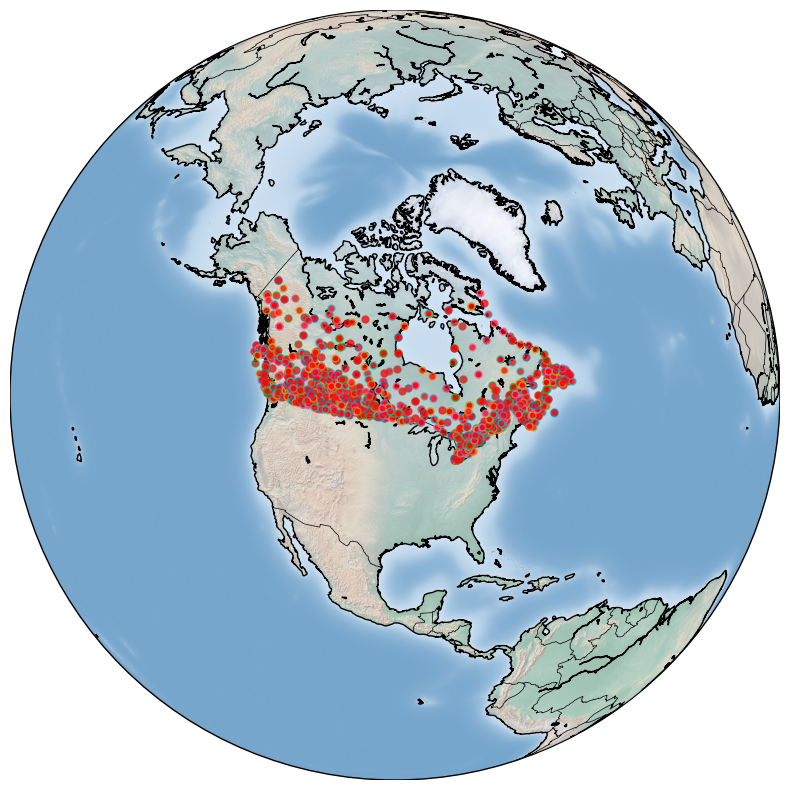

In [34]:
# Configurações globais para os gráficos
plt.rcParams['figure.figsize'] = (14, 10)  # Define o tamanho padrão da figura

# Definir limites geográficos
llon, ulon = -140, -50  # Limites de longitude
llat, ulat = 40, 65     # Limites de latitude

# Filtrar os dados com base nos limites geográficos
pdf = pdf[(pdf['Long'] > llon) & (pdf['Long'] < ulon) & (pdf['Lat'] > llat) & (pdf['Lat'] < ulat)]

# Criar o mapa usando a projeção 'ortho', lat_0 e lon_0 para a projeção ortográfica
my_map = Basemap(
    projection='ortho',
    resolution='l',           # Resolução
    area_thresh=1000.0,       # Área mínima para desenhar feições
    lat_0=np.mean([llat, ulat]),  # Latitude central
    lon_0=np.mean([llon, ulon])   # Longitude central
)

# Desenhar feições do mapa
my_map.drawcoastlines()       # Desenhar linhas costeiras
my_map.drawcountries()        # Desenhar bordas dos países
my_map.fillcontinents(color='white', alpha=0.3)  # Preencher continentes com cor translúcida
my_map.shadedrelief()         # Adicionar relevo sombreado para maior visualização

# Converter coordenadas geográficas em coordenadas do mapa
xs, ys = my_map(np.asarray(pdf.Long), np.asarray(pdf.Lat))
pdf['xm'] = xs.tolist()
pdf['ym'] = ys.tolist()

# Plotar os pontos no mapa
for _, row in pdf.iterrows():
    my_map.plot(
        row.xm, row.ym,
        markerfacecolor=([1, 0, 0]),  # Cor vermelha para os marcadores
        marker='o',                   # Marcador circular
        markersize=5,                 # Tamanho do marcador
        alpha=0.75                    # Transparência do marcador
    )

# Exibir o mapa
plt.show()

### **Visualização do mapa usando projeção retangular**

---

Dados filtrados para o mapa: 1189, entradas dentro dos limites definidos.


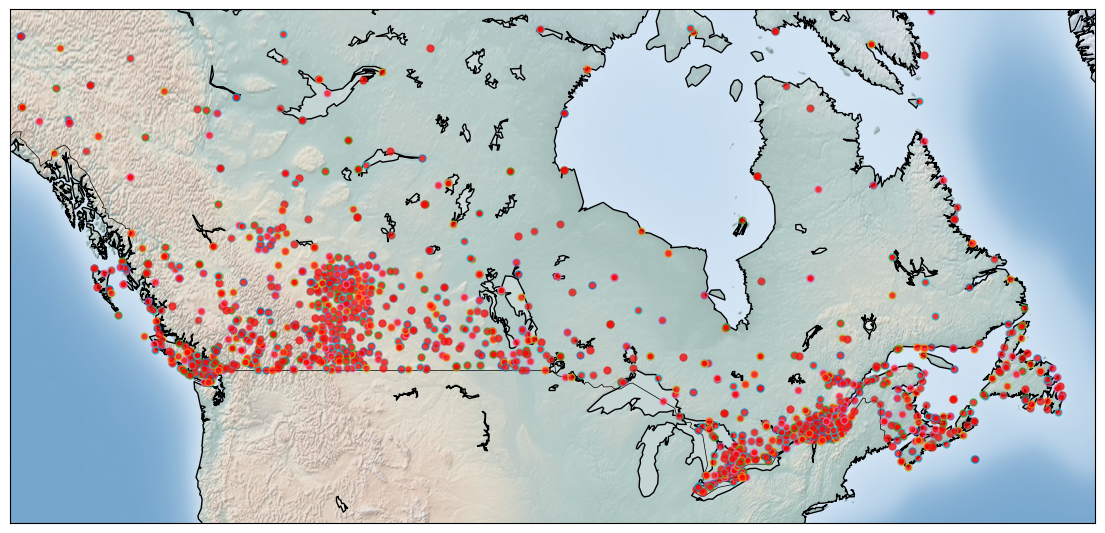

In [35]:
# Configurações globais para os gráficos
plt.rcParams['figure.figsize'] = (14, 10)  # Define o tamanho padrão da figura

# Definir limites geográficos
llon, ulon = -140, -50  # Limites de longitude
llat, ulat = 40, 65     # Limites de latitude

# Filtrar os dados com base nos limites geográficos
pdf = pdf[(pdf['Long'] > llon) & (pdf['Long'] < ulon) & (pdf['Lat'] > llat) & (pdf['Lat'] < ulat)]

# Exibir mensagem informativa sobre o filtro
print(f"Dados filtrados para o mapa: {len(pdf)}, entradas dentro dos limites definidos.")

# Criar o mapa usando a projeção 'mercator'
my_map = Basemap(
    projection='merc',
    resolution='l',           # Resolução baixa ('l' = low)
    area_thresh=1000.0,       # Área mínima para desenhar feições
    llcrnrlon=llon, llcrnrlat=llat,  # Canto inferior esquerdo
    urcrnrlon=ulon, urcrnrlat=ulat   # Canto superior direito
)

# Desenhar feições do mapa
my_map.drawcoastlines()       # Desenhar linhas costeiras
my_map.drawcountries()        # Desenhar bordas dos países
my_map.fillcontinents(color='white', alpha=0.3)  # Preencher continentes com cor translúcida
my_map.shadedrelief()         # Adicionar relevo sombreado ao mapa para dar um efeito 3D

# Converter coordenadas geográficas em coordenadas do mapa
xs, ys = my_map(np.asarray(pdf.Long), np.asarray(pdf.Lat))
pdf['xm'] = xs.tolist()
pdf['ym'] = ys.tolist()

# Plotar os pontos no mapa
for _, row in pdf.iterrows():
    my_map.plot(
        row.xm, row.ym,
        markerfacecolor=([1, 0, 0]),  # Define a cor do marcador no formato [R, G, B]
        marker='o',                   # 'o' marcador circular; 'x': Cruz; 's': Quadrado
        markersize=5,                 # Tamanho do marcador
        alpha=0.75                    # Transparência do marcador
    )

# Exibir o mapa
plt.show()

## **Clusterização de Estações Meteorológicas por Localização**

Para agrupar as estações meteorológicas com base em sua localização (latitude e longitude), utilizaremos o algoritmo DBSCAN (Density-Based Spatial Clustering of Applications with Noise) da biblioteca Scikit-learn.

O DBSCAN pode ser aplicado tanto a matrizes de vetores quanto a matrizes de distância. Neste caso, utilizaremos a matriz NumPy `Clus_dataSet`, que contém as coordenadas das estações, para identificar os pontos centrais de alta densidade e expandir os clusters a partir deles.

O DBSCAN utiliza dois principais parâmetros que controlam o comportamento de formação dos clusters e a detecção de outliers, `eps` e `min_samples`, a seguir cada parâmetro e suas implicações:

* `eps` (epsilon): Representa o raio de alcance (distância máxima) para considerar dois pontos como vizinhos.
  * Valores pequenos resultam em mais clusters e podem classificar pontos como ruído.
  * Valores grandes podem agrupar clusters densos em um único cluster, reduzindo a granularidade.

* `min_samples`: é o número mínimo de pontos necessários para formar um cluster, incluindo o ponto central. Um valor comum é `min_samples = dimensionalidade + 1` (se os dados têm 2 dimensões, usar 3).
  * Valores baixos geram mais clusters menores, reduzindo a robustez contra ruídos.
  * Valores altos faz com que clusters menores posam ser ignorados, classificando mais pontos como ruído.

**Demais parâmetros**:

* `metric`: define a métrica de distância usada para calcular a proximidade entre os pontos, pode ser:

  * `'euclidean'` (padrão): Distância euclidiana (L2).
  * `'manhattan'`: Distância Manhattan (L1).
  * `'minkowski'`: Distância generalizada (controlada pelo parâmetro p).
  * `'cosine'`: Similaridade de cosseno.

* `algorithm`: define o algoritmo usado para calcular os vizinhos de um ponto.
  * `'auto'` (padrão): Escolhe automaticamente o melhor algoritmo com base nos dados.
  * `'ball_tree'`: Utiliza árvores de bolas para buscas eficientes.
  * `'kd_tree'`: Utiliza árvores KD (K-Dimensional).
  * `'brute'`: Força bruta (calcula todas as distâncias).

**Resumo das opções**

| **Parâmetro**  | **Descrição**                            | **Padrão**      | **Notas**                                           |
|----------------|------------------------------------------|-----------------|----------------------------------------------------|
| `eps`          | Raio de busca para vizinhos             | Necessário      | Valor crítico para definir clusters.              |
| `min_samples`  | Mínimo de pontos para formar um cluster | Necessário      | Deve ser ajustado com base na densidade esperada dos dados. |
| `metric`       | Métrica de distância                    | `'euclidean'`   | Pode ser ajustada para dados com diferentes características. |
| `algorithm`    | Algoritmo para busca de vizinhos        | `'auto'`        | Influencia o desempenho.                          |
| `leaf_size`    | Tamanho das folhas para árvores de busca| `30`            | Impacta a performance.                            |
| `p`            | Parâmetro da distância Minkowski        | `2`             | Ajusta a métrica de distância.                    |


In [36]:
# Garantir reprodutibilidade do resultado com uma semente fixa
random_state = 1000  # Define o estado aleatório
np.random.seed(random_state)

# Selecionar as colunas relevantes para clustering
Clus_dataSet = pdf[['xm', 'ym']].copy()

# Substituir valores NaN por zero
Clus_dataSet = np.nan_to_num(Clus_dataSet)

# Escalar os dados para padronizar as métricas
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Aplicar o algoritmo DBSCAN
eps_value = 0.15  # Define o raio de alcance para os clusters
min_samples_value = 10  # Define o número mínimo de pontos em um cluster

db = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(Clus_dataSet)

# Criar máscara para identificar pontos centrais dos clusters
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Obter os rótulos de cluster
labels = db.labels_

# Adicionar os rótulos de cluster ao dataframe original
pdf["Clus_Db"] = labels

# Determinar o número de clusters reais (excluindo outliers, identificados como -1)
realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

# Informações sobre os clusters
print(f"\nNúmero total de clusters (incluindo outliers): {clusterNum}")
print(f"Número de clusters reais (excluindo outliers): {realClusterNum}")

# Exibir os primeiros registros com as informações de cluster
print("\nPrimeiras 5 linhas do dataframe com rótulos de cluster:")
pdf[["Stn_Name", "Tx", "Tm", "Clus_Db"]].head(5)


Número total de clusters (incluindo outliers): 6
Número de clusters reais (excluindo outliers): 5

Primeiras 5 linhas do dataframe com rótulos de cluster:


Stn_Name    Tx   Tm  Clus_Db
0               CHEMAINUS  13.5  8.2        0
1  COWICHAN LAKE FORESTRY  15.0  7.0        0
2           LAKE COWICHAN  16.0  6.8        0
3     DUNCAN KELVIN CREEK  14.5  7.7        0
4       ESQUIMALT HARBOUR  13.1  8.8        0

In [37]:
set(labels)

{-1, 0, 1, 2, 3, 4}


Densidade dos clusters:
Cluster 0: Density = 9.849992834828054e-11
Cluster 1: Density = 9.704890244076592e-11
Cluster 2: Density = 9.1417827876293e-11
Cluster 3: Density = 1.111403381335322e-10
Cluster 4: Density = 8.078128640177866e-11
Cluster -1: Density = 0


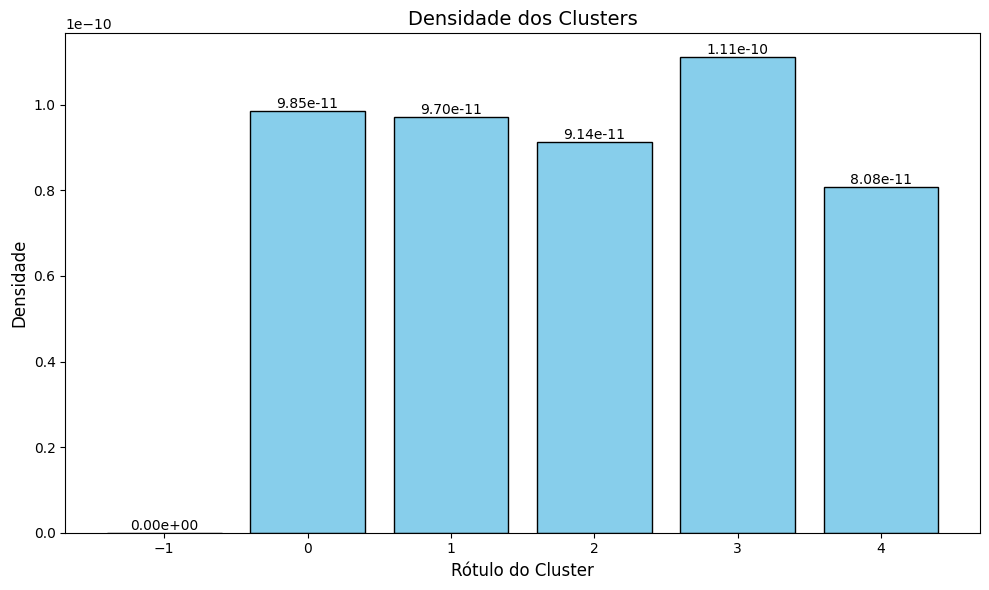

In [38]:
# Dicionário para armazenar a densidade de cada cluster
cluster_densities = {}

# Calcular a densidade para cada cluster
for cluster_label in set(labels):
    if cluster_label != -1:  # Excluir os outliers (rótulo -1)
        # Selecionar os pontos do cluster atual
        cluster_points = pdf[pdf["Clus_Db"] == cluster_label]

        # Determinar os limites do cluster (bounding box)
        min_x, max_x = cluster_points["xm"].min(), cluster_points["xm"].max()
        min_y, max_y = cluster_points["ym"].min(), cluster_points["ym"].max()

        # Calcular a área do bounding box
        area = (max_x - min_x) * (max_y - min_y)

        # Calcular a densidade (número de pontos / área)
        density = len(cluster_points) / area if area > 0 else 0  # Evitar divisão por zero

        # Armazenar a densidade no dicionário
        cluster_densities[cluster_label] = density
    else:
        # Definir densidade como 0 para outliers
        cluster_densities[cluster_label] = 0

# Exibir as densidades dos clusters no terminal
print("\nDensidade dos clusters:")
for cluster_label, density in cluster_densities.items():
    print(f"Cluster {cluster_label}: Density = {density}")

# Plotar gráfico de densidade dos culster
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_densities.keys(), cluster_densities.values(), color='skyblue', edgecolor='black')
plt.xlabel("Rótulo do Cluster", fontsize=12)
plt.ylabel("Densidade", fontsize=12)
plt.title("Densidade dos Clusters", fontsize=14)

# Adicionar valores no topo das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2e}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

## **Visualização da localização dos clusters**

---



Cluster 0: Temperatura média = -5.54
Cluster 1: Temperatura média = 1.95
Cluster 2: Temperatura média = -9.20
Cluster 3: Temperatura média = -15.30
Cluster 4: Temperatura média = -7.77


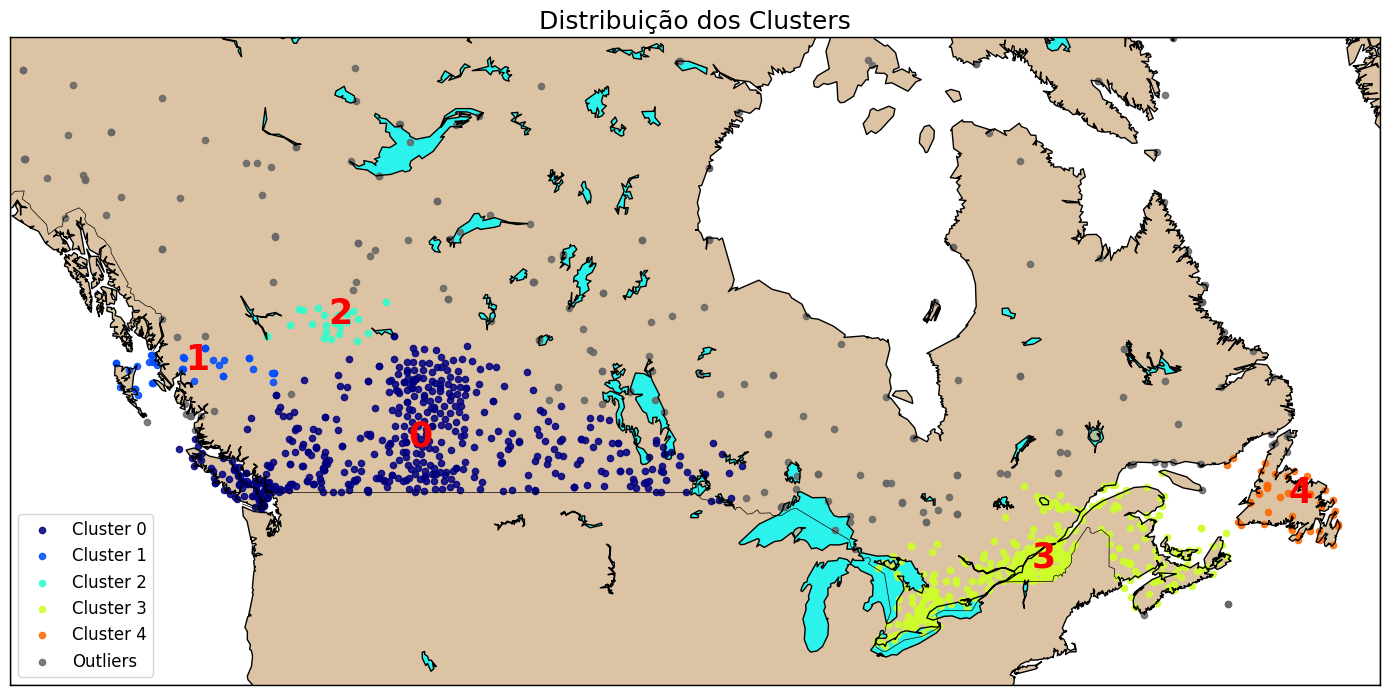

In [39]:
# Configurações globais para o tamanho da figura
plt.rcParams['figure.figsize'] = (14, 10)

# Configuração do mapa com Basemap
my_map = Basemap(
    projection='merc',
    resolution='l',          # Resolução
    area_thresh=1000.0,      # Limite mínimo de área para feições
    llcrnrlon=llon,          # Longitude inferior esquerda
    llcrnrlat=llat,          # Latitude inferior esquerda
    urcrnrlon=ulon,          # Longitude superior direita
    urcrnrlat=ulat           # Latitude superior direita
)

# Desenho dos elementos do mapa
my_map.drawcoastlines()       # Linhas costeiras
my_map.drawcountries()        # Bordas entre países
my_map.drawmapboundary()      # Borda do mapa
my_map.fillcontinents(color='tan', lake_color='aqua', alpha=0.8, zorder=1)
# my_map.fillcontinents(color='white', alpha=0.3)  # Continentes com cor branca e transparência
my_map.shadedrelief()         # Relevo sombreado

# Definir a paleta de cores para os clusters
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))

# Plotar os clusters e suas informações
for clust_number in set(labels):
    # Definir cor dos outliers (-1) como cinza
    c = ([0.4, 0.4, 0.4] if clust_number == -1 else colors[int(clust_number)])

    # Selecionar os pontos do cluster atual
    clust_set = pdf[pdf.Clus_Db == clust_number]

    # Plotar os pontos do cluster no mapa
    my_map.scatter(
        clust_set.xm, clust_set.ym,
        color=c, marker='o', s=20, alpha=0.85, label=f"Cluster {clust_number}" if clust_number != -1 else "Outliers"
    )

    # Adicionar o rótulo do cluster no centro do grupo (se não for outlier)
    if clust_number != -1:
        cenx = np.mean(clust_set.xm)  # Coordenada média x
        ceny = np.mean(clust_set.ym)  # Coordenada média y
        plt.text(cenx, ceny, str(clust_number), fontsize=25, color='red', weight='bold')
        print(f"Cluster {clust_number}: Temperatura média = {np.mean(clust_set.Tm):.2f}")

# Configuração final do mapa e exibição
plt.legend(loc='lower left', fontsize=12)  # Legenda para clusters
plt.title("Distribuição dos Clusters", fontsize=18)
plt.tight_layout()  # Ajustar layout para evitar sobreposição
plt.show()


## **Agrupamento de estações com base em sua localização e temperaturas: média, máxima e mínima**

---


Nesta seção, executamos novamente o DBSCAN, considerando o conjunto de dado em 5 dimensões.

In [40]:
# Garantir reprodutibilidade do resultado com uma semente fixa
random_state = 1000  # Define o estado aleatório
np.random.seed(random_state)

# Selecionar as colunas relevantes para clustering
Clus_dataSet = pdf[['xm','ym','Tx','Tm','Tn']].copy()

# Substituir valores NaN por zero
Clus_dataSet = np.nan_to_num(Clus_dataSet)

# Escalar os dados para padronizar as métricas
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Aplicar o algoritmo DBSCAN
eps_value = 0.3  # Define o raio de alcance para os clusters
min_samples_value = 10  # Define o número mínimo de pontos em um cluster

db = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(Clus_dataSet)

# Criar máscara para identificar pontos centrais dos clusters
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Obter os rótulos de cluster
labels = db.labels_

# Adicionar os rótulos de cluster ao dataframe original
pdf["Clus_Db"] = labels

# Determinar o número de clusters reais (excluindo outliers, identificados como -1)
realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

# Informações sobre os clusters
print(f"\nNúmero total de clusters (incluindo outliers): {clusterNum}")
print(f"Número de clusters reais (excluindo outliers): {realClusterNum}")

# Exibir os primeiros registros com as informações de cluster
print("\nPrimeiras 5 linhas do dataframe com rótulos de cluster:")
pdf[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)


Número total de clusters (incluindo outliers): 10
Número de clusters reais (excluindo outliers): 9

Primeiras 5 linhas do dataframe com rótulos de cluster:


Stn_Name    Tx   Tm  Clus_Db
0               CHEMAINUS  13.5  8.2        0
1  COWICHAN LAKE FORESTRY  15.0  7.0        0
2           LAKE COWICHAN  16.0  6.8        0
3     DUNCAN KELVIN CREEK  14.5  7.7        0
4       ESQUIMALT HARBOUR  13.1  8.8        0

In [41]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8}


Densidade dos clusters:
Cluster 0: Density = 1.7821728758055777e-10
Cluster 1: Density = 7.865591430873345e-11
Cluster 2: Density = 5.5204970545688556e-11
Cluster 3: Density = 5.1356611604970425e-11
Cluster 4: Density = 2.3200967531885846e-10
Cluster 5: Density = 9.806980083678278e-11
Cluster 6: Density = 1.5503891203807865e-10
Cluster 7: Density = 8.144348598396317e-11
Cluster 8: Density = 1.4100805585886458e-10
Cluster -1: Density = 0


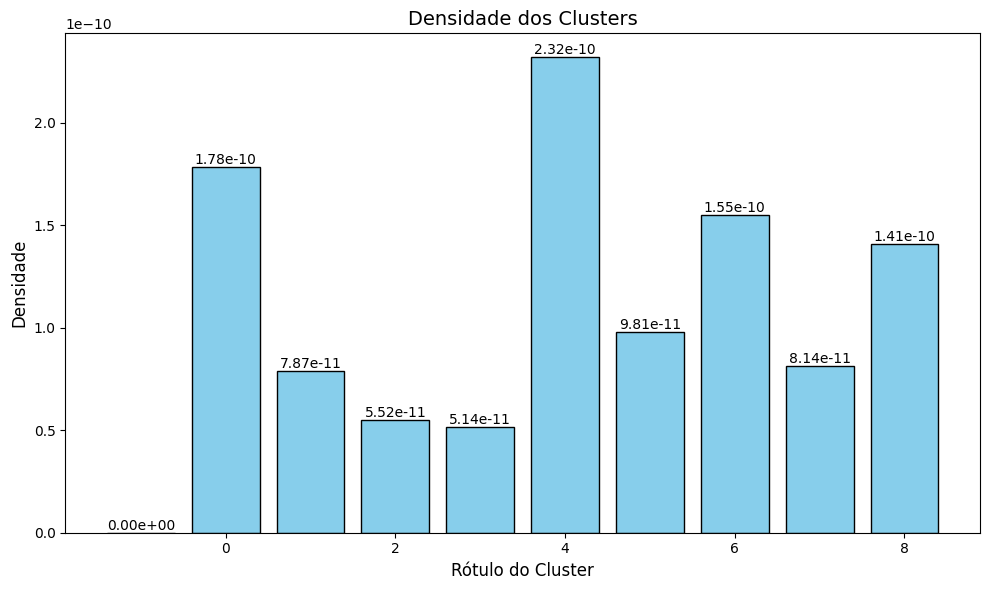

In [42]:
# Dicionário para armazenar a densidade de cada cluster
cluster_densities = {}

# Calcular a densidade para cada cluster
for cluster_label in set(labels):
    if cluster_label != -1:  # Excluir os outliers (rótulo -1)
        # Selecionar os pontos do cluster atual
        cluster_points = pdf[pdf["Clus_Db"] == cluster_label]

        # Determinar os limites do cluster (bounding box)
        min_x, max_x = cluster_points["xm"].min(), cluster_points["xm"].max()
        min_y, max_y = cluster_points["ym"].min(), cluster_points["ym"].max()

        # Calcular a área do bounding box
        area = (max_x - min_x) * (max_y - min_y)

        # Calcular a densidade (número de pontos / área)
        density = len(cluster_points) / area if area > 0 else 0  # Evitar divisão por zero

        # Armazenar a densidade no dicionário
        cluster_densities[cluster_label] = density
    else:
        # Definir densidade como 0 para outliers
        cluster_densities[cluster_label] = 0

# Exibir as densidades dos clusters no terminal
print("\nDensidade dos clusters:")
for cluster_label, density in cluster_densities.items():
    print(f"Cluster {cluster_label}: Density = {density}")

# Visualização da densidade dos clusters
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_densities.keys(), cluster_densities.values(), color='skyblue', edgecolor='black')
plt.xlabel("Rótulo do Cluster", fontsize=12)
plt.ylabel("Densidade", fontsize=12)
plt.title("Densidade dos Clusters", fontsize=14)

# Adicionar valores no topo das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2e}", ha='center', va='bottom')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## **Visualização da localização dos clusters com base na temperatura**

Cluster 0: Temperatura média = 6.22
Cluster 1: Temperatura média = 6.79
Cluster 2: Temperatura média = -0.49
Cluster 3: Temperatura média = -13.88
Cluster 4: Temperatura média = -4.19
Cluster 5: Temperatura média = -16.30
Cluster 6: Temperatura média = -13.60
Cluster 7: Temperatura média = -9.75
Cluster 8: Temperatura média = -4.26


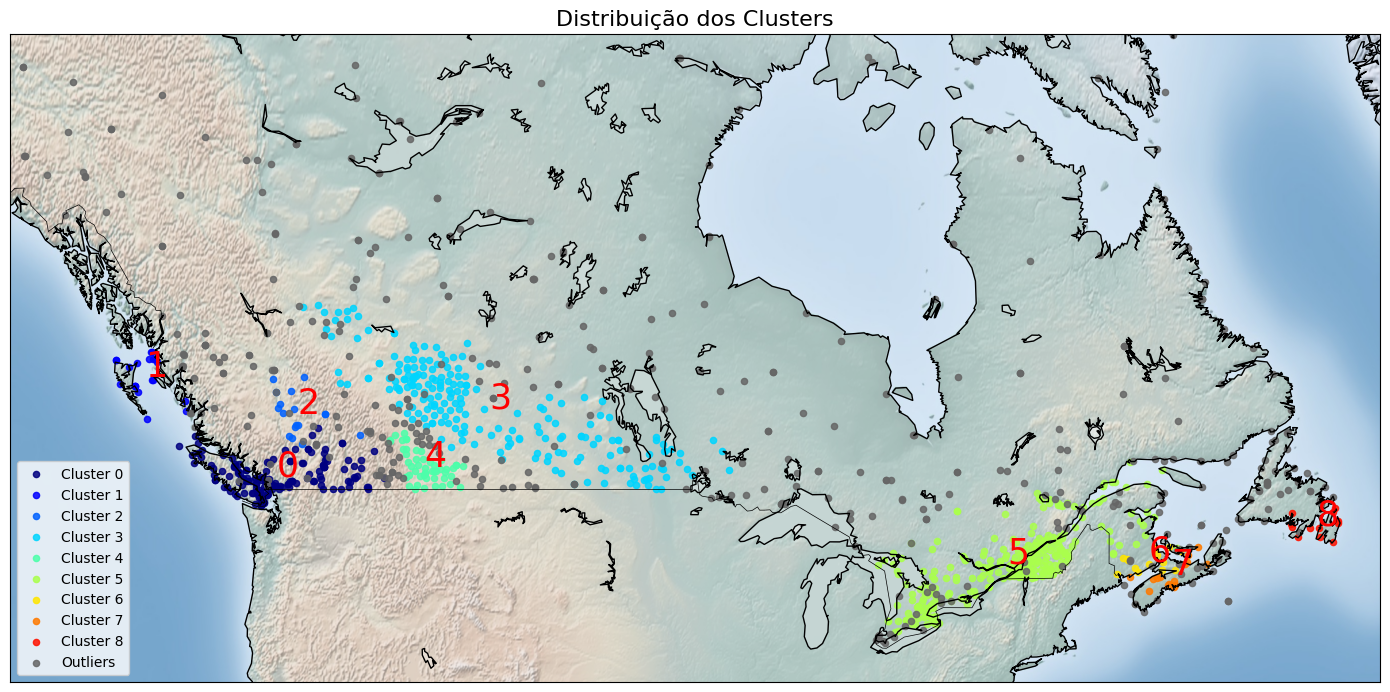

In [43]:
# Configurações globais para o tamanho da figura
rcParams['figure.figsize'] = (14,10)

# Configuração do mapa com Basemap
my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat,
            urcrnrlon=ulon, urcrnrlat=ulat)

# Desenho dos elementos do mapa
my_map.drawcoastlines()       # Linhas costeiras
my_map.drawcountries()        # Bordas entre países
# my_map.drawmapboundary()      # Borda do mapa
my_map.fillcontinents(color='white', alpha=0.3)  # Continentes com cor branca e transparência
my_map.shadedrelief()         # Relevo sombreado

# Definir a paleta de cores para os clusters
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))

# Plotar os clusters e suas informações
for clust_number in set(labels):
    # Definir cor dos outliers (-1) como cinza
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[int(clust_number)])

    # Selecionar os pontos do cluster atual
    clust_set = pdf[pdf.Clus_Db == clust_number]

    # Plotar os pontos do cluster no mapa
    my_map.scatter(
        clust_set.xm, clust_set.ym,
        color =c,  marker='o', s= 20, alpha = 0.85,
        label=f"Cluster {clust_number}" if clust_number != -1 else "Outliers"
    )
    # Adicionar o rótulo do cluster no centro do grupo (se não for outlier)
    if clust_number != -1:
        cenx = np.mean(clust_set.xm)  # Coordenada média x
        ceny = np.mean(clust_set.ym)  # Coordenada média y
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red') # , weight='bold'
        print(f"Cluster {clust_number}: Temperatura média = {np.mean(clust_set.Tm):.2f}")

# Configuração final do mapa e exibição
plt.legend(loc='best', fontsize=10)  # Legenda para clusters
plt.title("Distribuição dos Clusters", fontsize=16)
plt.tight_layout()  # Ajustar layout para evitar sobreposição
plt.show()

## **Referências**

  GÉRON, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. 2. ed. Sebastopol: O'Reilly Media, 2019. 856 p. ISBN 9781492032649.